<a href="https://colab.research.google.com/github/nudojacopo/thesis/blob/main/src/SYN/focus/hawkes_model_gab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import

In [1]:
!git clone https://github.com/nudojacopo/thesis.git
from google.colab import drive
drive.mount('/content/drive')
root='/content/'
import sys
module_path = root+'thesis/src/SYN'
sys.path.append(module_path)
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
!pip install powerlaw
from SYN_package.functions import *
from SYN_package.estimate_parameters import *
from SYN_package.hawkes_process import *
import json
from scipy import stats
import random
from scipy.stats import chi2
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
import powerlaw
import warnings

fatal: destination path 'thesis' already exists and is not an empty directory.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
from tqdm import tqdm
def create_hawkes_parameters(N,l,b):
    # Tassi base per i N processi
    lambda0 = np.ones(N)*l

    # Intensità dell'effetto dei processi
    alpha = np.ones((N, N)) - np.eye(N)

    # Parametri di decadimento per i N processi
    beta = np.ones(N) * b

    return lambda0, alpha, beta

def simulate_number_of_comments(alpha, lambda_, size=1):
    # Simulate the inflated component (produces 0 with probability alpha)
    inflate = np.random.binomial(1, alpha, size)

    # Simulate the count component (negative exponential distribution)
    counts = np.random.exponential(1 / lambda_, size) + 1
    counts = np.round(counts).astype(int)
    counts[counts < 0] = 0

    # Apply alpha probability to zero out counts where inflate is 1
    counts = counts * (1 - inflate)

    return counts

def simulate_hawkes_dependent(T, lambda0, alpha, beta,events,sizes):
    # Vettori per memorizzare i tempi degli eventi
    N =  len(events)# Eventi iniziali
    time = max([max(event_list) for event_list in events])

    # Simulazione degli eventi fino al tempo T
    while time < T:
        # Calcolo dell'intensità attuale per ciascun processo
        lambda_t = np.zeros(N)
        for i in range(N):
            lambda_t[i] = lambda0[i]
            for j in range(N):
                lambda_t[i] += sum(alpha[i, j] * np.exp(-beta[j] * (time - np.array(events[j]))))


        for i in range(N):
            if sizes[i]==len(events[i]):
                lambda_t[i]=0
        # Calcolo del tasso totale
        lambda_total = np.sum(lambda_t)

        if lambda_total==0:
            break
        # Tempo fino al prossimo evento
        time_to_next_event = np.random.exponential(1 / lambda_total)

        # Aggiornamento del tempo corrente
        time += time_to_next_event

        if time >= T:
            break

        # Determinazione del tipo di evento
        event_type = np.random.choice(list(range(N)), p=lambda_t / lambda_total)
        events[event_type].append(time)

    # Ritorno dei tempi degli eventi
    return events



def divide_in_gruppi(lista, dimensione):
    # Inizializza una lista vuota per contenere i gruppi
    gruppi = []

    # Calcola il numero di gruppi necessari
    num_gruppi = len(lista) // dimensione

    # Itera attraverso la lista e aggiungi gruppi di dimensione specificata alla lista di gruppi
    for i in range(num_gruppi):
        gruppi.append(lista[i * dimensione:(i + 1) * dimensione])

    # Se ci sono elementi rimanenti, aggiungi l'ultimo gruppo
    if len(lista) % dimensione != 0:
        gruppi.append(lista[num_gruppi * dimensione:])

    return gruppi
import random

def simulate_data_H(social, parameters,parameters_H=[12,0.1,2], num_threads=False, activate_tqdm=True, min_users=50):
    gamma=parameters['gamma']
    a=parameters['a']
    b=parameters['b']
    loc=parameters['loc']
    scale=parameters['scale']
    alpha=parameters['alpha']
    lambda_=parameters['lambda']
    data = []
    if num_threads:
        num_threads = min(num_threads, len(social['post_id'].unique()))
        thread_ids = random.sample(list(social['post_id'].unique()), num_threads)
    else:
        thread_ids = social['post_id'].unique()

    if activate_tqdm:
        thread_ids = tqdm(thread_ids)

    for th in thread_ids:
        thread = social[social['post_id'] == th]
        number_of_users = int(np.round(simulate_number_of_users(gamma, min_users, size=1)[0]))
        T0s = simulate_initial_comment(a, b, loc, scale, size=number_of_users)
        Ns=simulate_number_of_comments(alpha, lambda_,number_of_users)
        thread = [[T0s[i]] + [0] * (Ns[i] - 1) for i in range(number_of_users)]
        size_clique = parameters_H[2]  # Dimensione desiderata di ogni gruppo
        cliques = divide_in_gruppi(thread, size_clique)
        final=[]
        for clique  in cliques:
            # Replace nan with 0
            sizes = {i: len(sotto_lista) for i, sotto_lista in enumerate(clique)}
            N = len(clique)
            mu_a=parameters_H[0]
            mu_b=parameters_H[1]
            lambda0, alpha_H, beta_H = create_hawkes_parameters(N,mu_a,mu_b)

            events = [[sublist[0]] for sublist in clique]


            # Simulazione per un intervallo di tempo T
            T = 1
            events = simulate_hawkes_dependent(T, lambda0, alpha_H, beta_H,events,sizes)
            for interaction in events:
                for j, t in enumerate(interaction):
                    data.append({'user_id': f'User_{i}', 'post_id': th, 'temporal_distance_birth_base_100h': t, 'sequential_number_of_comment_by_user_in_thread': j + 1})

    simulated = pd.DataFrame(data)
    observed = social[social['post_id'].isin(simulated['post_id'].unique())][['user_id', 'post_id', 'temporal_distance_birth_base_100h', 'sequential_number_of_comment_by_user_in_thread']]

    return simulated, observed


def create_hawkes_parameters(N,mu_a,mu_b):
    # Tassi base per i N processi
    lambda0 = np.random.normal(mu_a, 1, size=N)

    # Intensità dell'effetto dei processi
    alpha = np.ones((N, N)) - np.eye(N)

    # Parametri di decadimento per i N processi
    beta = np.random.normal(mu_b, 0.01, size=N)

    return lambda0, alpha, beta



## Set up

In [2]:
# Choose settings for the parameters part
estimate_parameters=False # to estimate parameters
name_parameters='params_dict_trial' # good for ZIE separated

n=500 # number of threads
h=100 # number of hours considered

## Prepare Data

In [3]:
gb=pd.read_csv('/content/drive/MyDrive/thesis/data/gab/gab_PRO.csv')



gb=filter_first_h(gb,h)


names = ['gb']
datas = [gb]

## Search parameters

In [4]:
if estimate_parameters:
  params_dict = process_social_platform(names, datas)
  file_path = '/content/drive/MyDrive/thesis/data/parameters/'+name_parameters+'.json'
  os.makedirs(os.path.dirname(file_path), exist_ok=True)
  with open(file_path, 'w') as file:
      json.dump(params_dict, file)
else:
  with open('/content/drive/MyDrive/thesis/data/parameters/'+name_parameters+'.json', 'r') as file:
    params_dict = json.load(file)

## Simulate synthetic data

In [ ]:
from ctypes import c_ssize_t
import pandas as pd
from scipy import stats


# Definizione degli intervalli di ricerca
a_values = np.arange(5, 21,5)
b_values = np.arange(0.2, 0.55, 0.1)
N_values = np.arange(2, 6, 1)

# Parametri di simulazione comuni
social = 'gb'
parameters = params_dict['gb']
time_intervals = np.arange(0, 1, 0.05)
n = 100

# Placeholder per il miglior risultatoa
best_p_value = 0

# Grid search
for a in tqdm(a_values):
    for b in b_values:
        for N in N_values:
            paramters_h = [a, b, N]

            all_dfs = []
            social = 'gb'
            parameters = params_dict['gb']

            simulated_t, observed_t = simulate_data_H(gb, parameters,paramters_h, activate_tqdm=False, min_users=50,num_threads=n)
            globals()[f"{social}s_M2"] = simulated_t
            globals()[f"{social}o_M2"] = observed_t

            simulated_t_ECDF = calculate_ECDF(simulated_t, time_intervals,activate_tqdm=False)
            simulated_t_ECDF['Platform'] = social
            simulated_t_ECDF['Style'] = 'Simulated'

            observed_t_ECDF = calculate_ECDF(observed_t, time_intervals,activate_tqdm=False)
            observed_t_ECDF['Platform'] = social
            observed_t_ECDF['Style'] = 'Observed'

            df_platform = pd.concat([simulated_t_ECDF, observed_t_ECDF], ignore_index=False)
            all_dfs.append(df_platform)

            df_all_M1 = pd.concat(all_dfs, ignore_index=False)


            social='gb'
            simulated_shares = df_all_M1[(df_all_M1['Style'] == 'Simulated') & (df_all_M1['Platform'] ==social)]['Share']
            observed_shares = df_all_M1[(df_all_M1['Style'] == 'Observed') & (df_all_M1['Platform'] ==social)]['Share']

            ks_stat, p_value = stats.ks_2samp(simulated_shares, observed_shares)
            if p_value > best_p_value:
              best_p_value = p_value
              best_params = (a, b, N)
print("Miglior p-value:", best_p_value)
print("Migliori parametri (a, b, N):", best_params)



 50%|█████     | 2/4 [03:29<03:28, 104.42s/it]

# Signals

## Dynamic

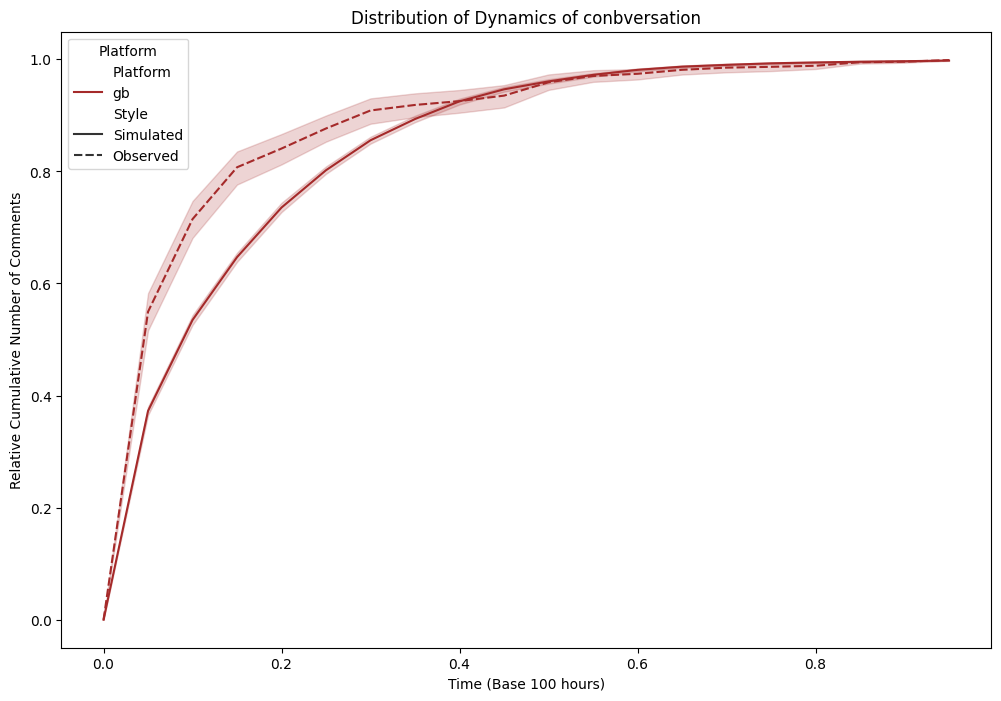

In [18]:
# Prepare data
palette = {'rd': 'purple', 'vo': 'green', 'fb': 'blue', 'yt': 'red','gb':'brown'}
df_all = df_all_M1.sort_values(by='Style')

# Plot comment arrival dynamic
plt.figure(figsize=(12, 8))
sns.lineplot(data=df_all_M1, x='Time Grid Value', y='Share', hue='Platform', style='Style', err_style='band', errorbar=('ci', 80), palette=palette)
plt.title('Distribution of Dynamics of conbversation')
plt.ylabel('Relative Cumulative Number of Comments')
plt.xlabel('Time (Base 100 hours)')
plt.grid(False)
plt.legend(title='Platform')
plt.show()

# Calculate Loss
df_line1 = df_all_M1[df_all_M1['Style'] == 'Simulated']
df_line2 = df_all_M1[df_all_M1['Style'] == 'Observed']
df_line1 = df_line1.set_index(['Time Grid Value', 'Platform'])
df_line2 = df_line2.set_index(['Time Grid Value', 'Platform'])
df_merged = df_line1.join(df_line2, lsuffix='_line1', rsuffix='_line2')
mse_per_platform_M1 = df_merged.groupby('Platform').apply(lambda x: np.mean((x['Share_line1'] - x['Share_line2'])**2))

In [23]:
import pandas as pd
from scipy import stats
social='gb'
# Estrazione dei dati pertinenti
simulated_shares = df_all_M1[(df_all_M2['Style'] == 'Simulated') & (df_all_M2['Platform'] ==social)]['Share']
observed_shares = df_all_M1[(df_all_M2['Style'] == 'Observed') & (df_all_M2['Platform'] ==social)]['Share']

# Esecuzione del test di Kolmogorov-Smirnov
ks_stat, p_value = stats.ks_2samp(simulated_shares, observed_shares)

ks_stat, p_value


(0.2495, 4.673837980931244e-55)

### Interaction Model - M2

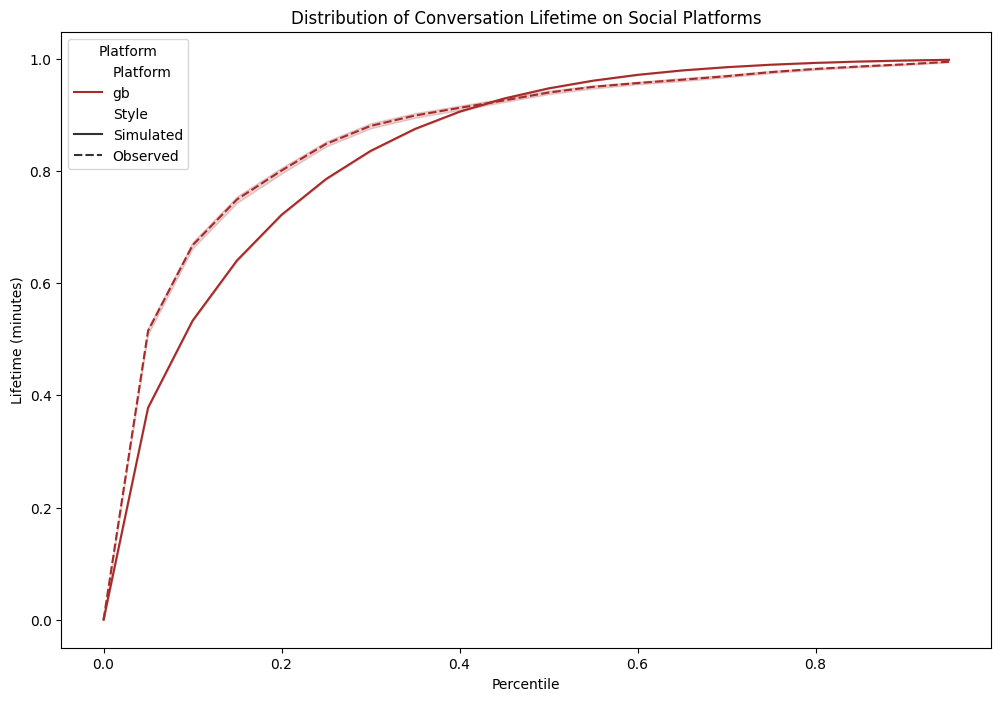

In [ ]:


# Calculate Loss
df_line1 = df_all_M2[df_all_M2['Style'] == 'Simulated']
df_line2 = df_all_M2[df_all_M2['Style'] == 'Observed']
df_line1 = df_line1.set_index(['Time Grid Value', 'Platform'])
df_line2 = df_line2.set_index(['Time Grid Value', 'Platform'])
df_merged = df_line1.join(df_line2, lsuffix='_line1', rsuffix='_line2')
mse_per_platform_M2 = df_merged.groupby('Platform').apply(lambda x: np.mean((x['Share_line1'] - x['Share_line2'])**2))
print(mse_per_platform_M2)

### Comparison Dyanamics Loss

In [16]:
mse_df = pd.DataFrame({
    'M1': mse_per_platform_M1,
    'M2': mse_per_platform_M2
}).reset_index()

fig, ax = plt.subplots(figsize=(10, 6))

mse_df.plot(kind='bar', x='Platform', ax=ax)

plt.title('Comparison of MSE per Platform for Model 1 and Model 2')
plt.xlabel('Platform')
plt.ylabel('Mean Squared Error')
plt.xticks(rotation=45)
plt.legend(['Model 1', 'Model 2'])
plt.tight_layout()

plt.show()
print(mse_df)

NameError: name 'mse_per_platform_M2' is not defined

## Partecipation

In [101]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm  # tqdm for progress bar

# Assuming rd, fb, vo, yt are your DataFrames

# Add 'platform' column to each DataFrame
rdo_M1['platform'] = 'Reddit'
voo_M1['platform'] = 'Voat'
fbo_M1['platform'] = 'Facebook'
gbo_M1['platform'] = 'Gab'
# Combine all DataFrames into a single DataFrame
all_data = []

# Process each dataset individually
for df in tqdm([rdo_M1,  voo_M1,fbo_M1,gbo_M1]):#yto
    df['number_of_comments'] = df.groupby('post_id')['post_id'].transform('count')
    df['sequential_position'] = df.groupby('post_id')['temporal_distance_birth_base_100h'].rank(method='first')

    # Determine the number of bins
    num_bins = 30

    # Calculate the bin of position
    df['bin_of_position'] = ((df['sequential_position'] - 1) / df['number_of_comments'] * num_bins).astype(int) + 1
    df['first_comment']=df['sequential_number_of_comment_by_user_in_thread']==1
    # Group by 'bin_of_position', 'post_id', and calculate unique users per post
    df['first_comment'] = df.groupby(['bin_of_position', 'post_id'])['first_comment'].transform('mean')
    all_data.append(df)
all_data = pd.concat(all_data, ignore_index=True)
# Aggregate data across all datasets
agg_activity_obs = all_data.groupby(['platform', 'bin_of_position', 'post_id'])['first_comment'].mean().reset_index()


100%|██████████| 4/4 [00:00<00:00, 21.27it/s]


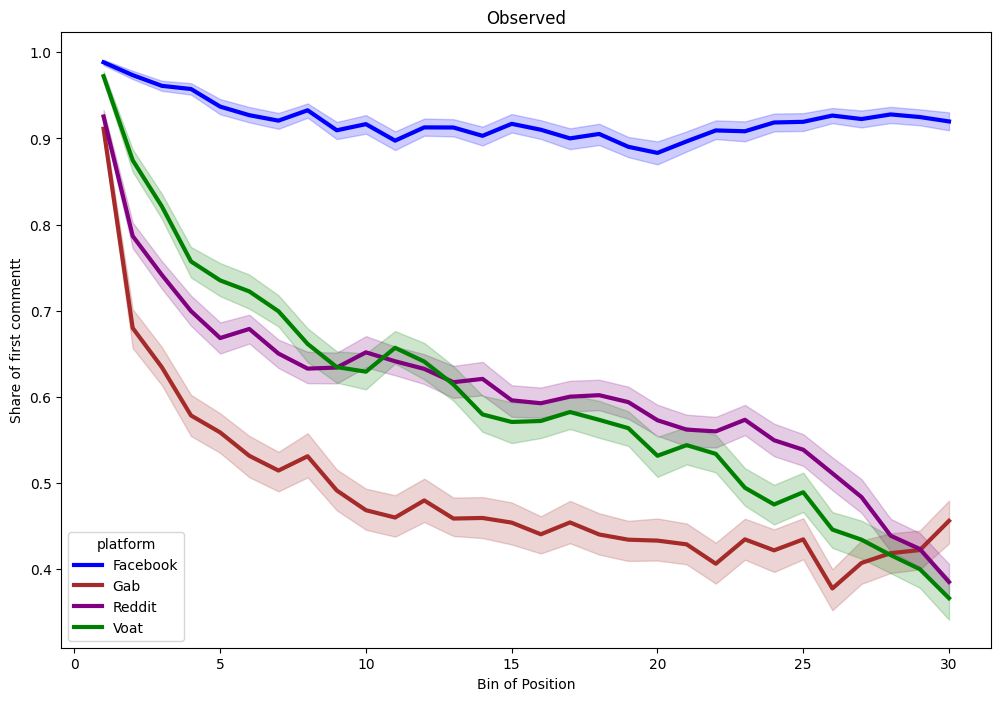

In [102]:
plt.figure(figsize=(12, 8))
sns.lineplot(
    data=agg_activity_obs,
    x='bin_of_position',
    y='first_comment',
    hue='platform',  # Different line for each platform
    estimator='mean',  # or 'sum', 'median', etc. depending on your aggregation preference
    errorbar=('ci', 80),  # 99.999% confidence interval
    linewidth=3,
    palette={'Reddit': 'purple', 'Voat': 'green', 'Facebook': 'blue','Gab': 'brown'}#,'YouTube':'red'}  # Custom palette with specified colors
)
plt.title('Observed')
plt.ylabel('Share of first commentt')
plt.xlabel('Bin of Position')
plt.grid(False)
plt.show()


#### M1

In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm  # tqdm for progress bar

# Assuming rd, fb, vo, yt are your DataFrames

# Add 'platform' column to each DataFrame
rds_M1['platform'] = 'Reddit'
vos_M1['platform'] = 'Voat'
fbs_M1['platform'] = 'Facebook'
gbs_M1['platform'] = 'Gab'
# Combine all DataFrames into a single DataFrame
all_data = []

# Process each dataset individually
for df in tqdm([rds_M1,  vos_M1,fbs_M1,gbs_M1]):#yto
    df['number_of_comments'] = df.groupby('post_id')['post_id'].transform('count')
    df['sequential_position'] = df.groupby('post_id')['temporal_distance_birth_base_100h'].rank(method='first')

    # Determine the number of bins
    num_bins = 30

    # Calculate the bin of position
    df['bin_of_position'] = ((df['sequential_position'] - 1) / df['number_of_comments'] * num_bins).astype(int) + 1

    df['first_comment']=df['sequential_number_of_comment_by_user_in_thread']==1
    # Group by 'bin_of_position', 'post_id', and calculate unique users per post
    df['first_comment'] = df.groupby(['bin_of_position', 'post_id'])['first_comment'].transform('mean')
    all_data.append(df)
all_data = pd.concat(all_data, ignore_index=True)
# Aggregate data across all datasets
agg_activity_sim_M1 = all_data.groupby(['platform', 'bin_of_position', 'post_id'])['first_comment'].mean().reset_index()



100%|██████████| 4/4 [00:00<00:00,  7.77it/s]


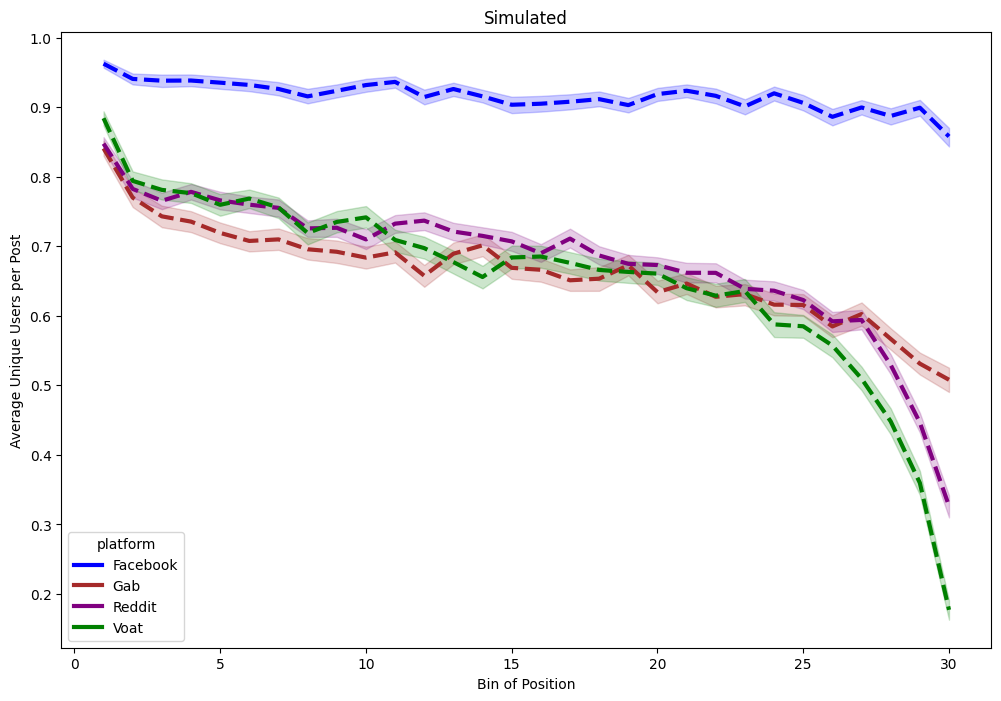

In [104]:
plt.figure(figsize=(12, 8))

# Create the line plot
sns.lineplot(
    data=agg_activity_sim_M1,
    x='bin_of_position',
    y='first_comment',
    hue='platform',  # Different line for each platform
    estimator='mean',  # Aggregation preference
    errorbar=('ci', 80),  # 80% confidence interval
    linewidth=3,
    palette={'Reddit': 'purple', 'Voat': 'green', 'Facebook': 'blue', 'Gab': 'brown'},  # Adding style for dashed line
)

# Manually setting the line style for one of the platforms
lines = plt.gca().get_lines()
for line in lines:
  line.set_linestyle('--')

plt.title('Simulated')
plt.ylabel('Average Unique Users per Post')
plt.xlabel('Bin of Position')
plt.grid(False)

plt.show()


#### M2

In [105]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm  # tqdm for progress bar

# Assuming rd, fb, vo, yt are your DataFrames

# Add 'platform' column to each DataFrame
rds_M2['platform'] = 'Reddit'
vos_M2['platform'] = 'Voat'
fbs_M2['platform'] = 'Facebook'
gbs_M2['platform'] = 'Gab'
# Combine all DataFrames into a single DataFrame
all_data = []

# Process each dataset individually
for df in tqdm([rds_M2,  vos_M2,fbs_M2,gbs_M2]):#yto
    df['number_of_comments'] = df.groupby('post_id')['post_id'].transform('count')
    df['sequential_position'] = df.groupby('post_id')['temporal_distance_birth_base_100h'].rank(method='first')

    # Determine the number of bins
    num_bins = 30

    # Calculate the bin of position
    df['bin_of_position'] = ((df['sequential_position'] - 1) / df['number_of_comments'] * num_bins).astype(int) + 1
    df['first_comment']=df['sequential_number_of_comment_by_user_in_thread']==1
    # Group by 'bin_of_position', 'post_id', and calculate unique users per post
    df['first_comment'] = df.groupby(['bin_of_position', 'post_id'])['first_comment'].transform('mean')
    all_data.append(df)
all_data = pd.concat(all_data, ignore_index=True)
# Aggregate data across all datasets
agg_activity_sim_M2 = all_data.groupby(['platform', 'bin_of_position', 'post_id'])['first_comment'].mean().reset_index()


100%|██████████| 4/4 [00:00<00:00, 12.49it/s]


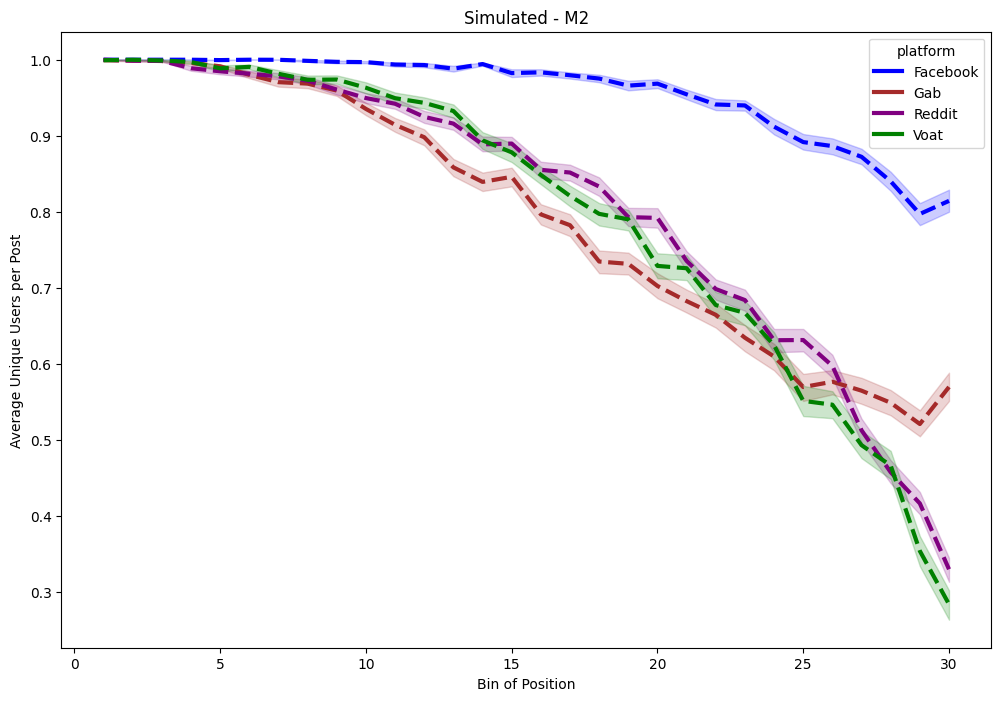

In [106]:
plt.figure(figsize=(12, 8))

# Create the line plot
sns.lineplot(
    data=agg_activity_sim_M2,
    x='bin_of_position',
    y='first_comment',
    hue='platform',  # Different line for each platform
    estimator='mean',  # Aggregation preference
    errorbar=('ci', 80),  # 80% confidence interval
    linewidth=3,
    palette={'Reddit': 'purple', 'Voat': 'green', 'Facebook': 'blue', 'Gab': 'brown'},  # Adding style for dashed line
)

# Manually setting the line style for one of the platforms
lines = plt.gca().get_lines()
for line in lines:
  line.set_linestyle('--')

plt.title('Simulated - M2')
plt.ylabel('Average Unique Users per Post')
plt.xlabel('Bin of Position')
plt.grid(False)
plt.show()


##### Loss comparison

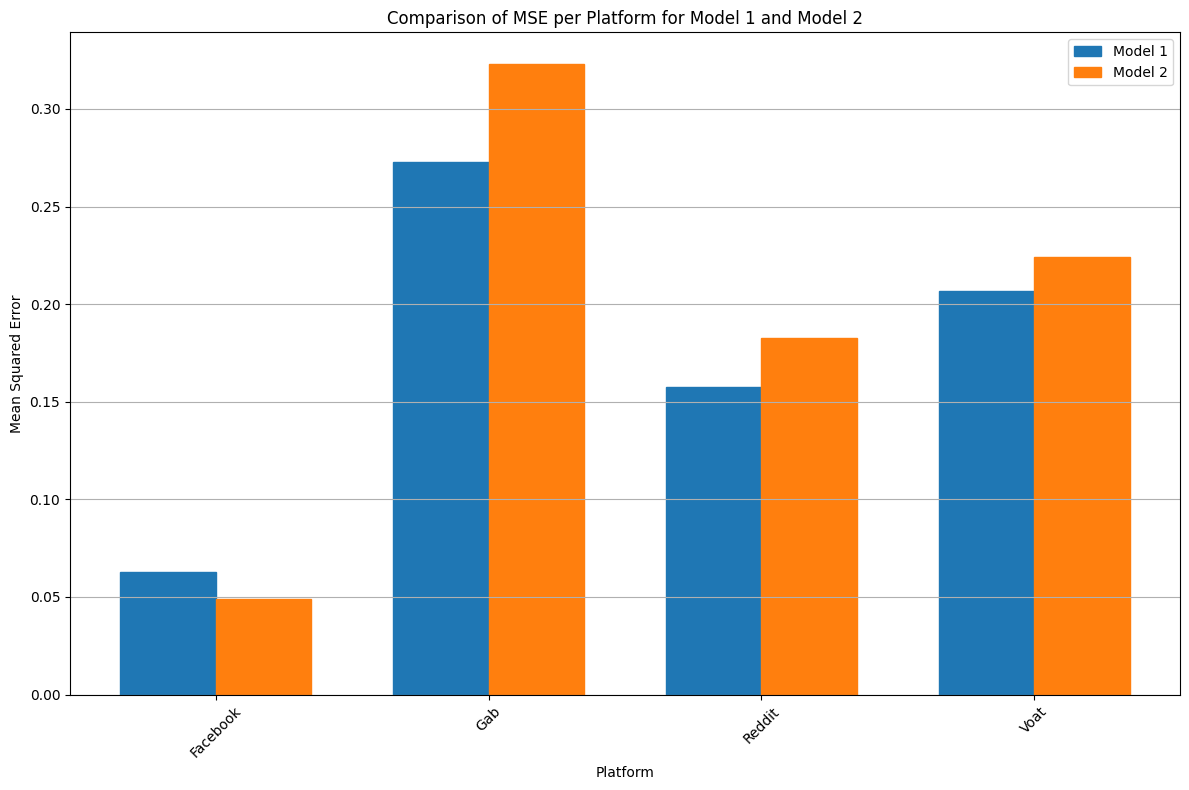

   platform        M1        M2
0  Facebook  0.062537  0.048957
1       Gab  0.272863  0.323120
2    Reddit  0.157403  0.182724
3      Voat  0.206847  0.223987


In [107]:


# Calculate MSE for each platform for Model 1
df_line1_M1 = agg_activity_sim_M1
df_line2 = agg_activity_obs

df_line1_M1 = df_line1_M1.set_index(['bin_of_position', 'platform'])
df_line2 = df_line2.set_index(['bin_of_position', 'platform'])

df_merged_M1 = df_line1_M1.join(df_line2, lsuffix='_line1', rsuffix='_line2')
mse_per_platform_M1 = df_merged_M1.groupby('platform').apply(
    lambda x: np.mean((x['first_comment_line1'] - x['first_comment_line2'])**2))

# Calculate MSE for each platform for Model 2
df_line1_M2 = agg_activity_sim_M2  # Assuming you have a similar DataFrame for Model 2
df_line1_M2 = df_line1_M2.set_index(['bin_of_position', 'platform'])

df_merged_M2 = df_line1_M2.join(df_line2, lsuffix='_line1', rsuffix='_line2')
mse_per_platform_M2 = df_merged_M2.groupby('platform').apply(
    lambda x: np.mean((x['first_comment_line1'] - x['first_comment_line2'])**2))

# Combine MSE data into a single DataFrame for plotting
mse_df = pd.DataFrame({
    'M1': mse_per_platform_M1,
    'M2': mse_per_platform_M2
}).reset_index()

# Plotting the comparison
fig, ax = plt.subplots(figsize=(12, 8))

# Define colors and edgecolors
colors = ['#1f77b4', '#ff7f0e']
edgecolors = ['#1f77b4', '#ff7f0e']

# Plot bars with custom colors and borders
bar_width = 0.35
index = np.arange(len(mse_df))

bar1 = ax.bar(index, mse_df['M1'], bar_width, color=colors[0], edgecolor=edgecolors[0], label='Model 1')
bar2 = ax.bar(index + bar_width, mse_df['M2'], bar_width, color=colors[1], edgecolor=edgecolors[1], label='Model 2')

# Add labels, title, and legend
ax.set_xlabel('Platform')
ax.set_ylabel('Mean Squared Error')
ax.set_title('Comparison of MSE per Platform for Model 1 and Model 2')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(mse_df['platform'], rotation=45)
ax.legend()

# Add a grid for better readability
ax.yaxis.grid(True)

plt.tight_layout()
plt.show()

print(mse_df)